Installing pre-requisites

In [1]:
!pip install pytorch-metric-learning
!pip install faiss-gpu

     |████████████████████████████████| 102kB 4.0MB/s 
     |████████████████████████████████| 89.4MB 48kB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Part 1: Data import and dataframe creation

Importing important libraries

In [4]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets

In [6]:
transform = transforms.Compose(
    [transforms.Resize(220),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5], std=[0.5])])

In [7]:
mnistTrain = datasets.MNIST('.', train=True, download=True, transform=transform)
mnistTest = datasets.MNIST('.', train=False, transform=transform)
mnistTrainLoader = torch.utils.data.DataLoader(mnistTrain, batch_size=128, shuffle=True)
mnistTestLoader = torch.utils.data.DataLoader(mnistTest, batch_size=128)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [8]:
def  displayImage(image):
    image = image/2 + 0.5
    image = image.numpy()
    image = image.reshape(220,220)
    return image

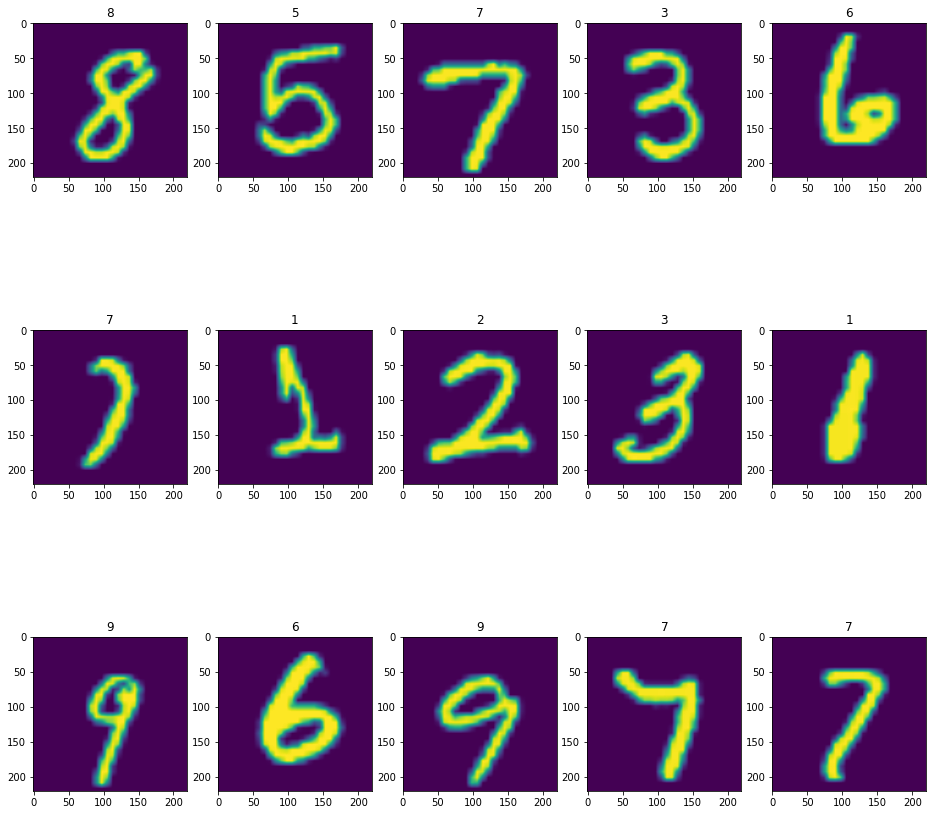

In [9]:
dataIterator = iter(mnistTrainLoader)
images, labels = dataIterator.next()
figure, axis = plt.subplots(3,5, figsize=(16,16))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(displayImage(image))
        ax.set(title=f"{label.item()}")

## Part 2: Defining the neural network and initiating the training

Importing libraries

In [10]:
#the pytorch metric learning library comes with inbuilt methods for triplet mining and computing triplet losses between anchor, positive class and negative class
from pytorch_metric_learning import losses, miners
from pytorch_metric_learning.distances import CosineSimilarity
from pytorch_metric_learning.reducers import ThresholdReducer
from pytorch_metric_learning.regularizers import LpRegularizer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Training the model on: ",device, " Available GPU: ", torch.cuda.get_device_name(0))

Training the model on:  cuda:0  Available GPU:  Tesla P100-PCIE-16GB


In [12]:
class EmbeddingNetwork(nn.Module):
    def __init__(self):
        super(EmbeddingNetwork, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, (7,7), stride=(2,2), padding=(3,3)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.001),
            nn.MaxPool2d((3, 3), 2, padding=(1,1))
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64,64,(1,1), stride=(1,1)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.001),
            nn.Conv2d(64,192, (3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(0.001),
            nn.MaxPool2d((3,3),2, padding=(1,1))
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(192,192,(1,1), stride=(1,1)),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(0.001),
            nn.Conv2d(192,384,(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(384),
            nn.LeakyReLU(0.001),
            nn.MaxPool2d((3,3), 2, padding=(1,1))
            )
        self.conv4 = nn.Sequential(
            nn.Conv2d(384,384,(1,1), stride=(1,1)),
            nn.BatchNorm2d(384),
            nn.LeakyReLU(0.001),
            nn.Conv2d(384,256,(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.001)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(256,256,(1,1), stride=(1,1)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.001),
            nn.Conv2d(256,256,(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.001)
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(256,256,(1,1), stride=(1,1)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.001),
            nn.Conv2d(256,256,(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.001),
            nn.MaxPool2d((3,3),2, padding=(1,1)),
            nn.Flatten()
        )
        self.fullyConnected = nn.Sequential(
            nn.Linear(7*7*256,32*128),
            nn.BatchNorm1d(32*128),
            nn.LeakyReLU(0.001),
            nn.Linear(32*128,128)
        )
    def forward(self,x):
      x = self.conv1(x)
      x = self.conv2(x)
      x = self.conv3(x)
      x = self.conv4(x)
      x = self.conv5(x)
      x = self.conv6(x)
      x = self.fullyConnected(x)
      return torch.nn.functional.normalize(x, p=2, dim=-1)

In [13]:
embeddingNetwork = EmbeddingNetwork().to(device)
print(embeddingNetwork)

EmbeddingNetwork(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.001)
    (3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=(1, 1), dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.001)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.001)
    (6): MaxPool2d(kernel_size=(3, 3), stride=2, padding=(1, 1), dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(192, 192, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affin

In [14]:
def trainMNIST(model, lossFunction, miningFunction, device, trainLoader, optimizer, epoch):
    print("Training started for Epoch: ",epoch)
    model.train()
    for batchIndex, (data, labels) in enumerate(trainLoader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data)
        hardPairs = miningFunction(embeddings, labels)
        loss = lossFunction(embeddings, labels, hardPairs)
        loss.backward()
        optimizer.step()
        if batchIndex%300==0:
            print("Training Stats for Epoch {} Iteration {}: Loss= {}, Number of mined triplets {}".format(epoch, batchIndex, loss, miningFunction.num_triplets))

In [15]:
#distance this tells the model how to calculate the distance between the  generated embeddings
distance = CosineSimilarity()
reducer = ThresholdReducer(low=0.0)
lossFunction = losses.TripletMarginLoss(margin = 0.2, distance = distance, reducer = reducer)
miningFunction = miners.TripletMarginMiner(margin = 0.2, distance = distance, type_of_triplets = "semi-hard")
optimizer = torch.optim.Adam(embeddingNetwork.parameters(), lr=0.05)

In [17]:
maxValidationAccuracyMNIST = 0.0
def testerMNIST(maxValidationAccuracyMNIST):
  trainEmbeddings = []
  trainLabels = []
  validationEmbeddings = []
  validationLabels = []
  with torch.no_grad():
    embeddingNetwork.eval()
    for (dataTr, labelTr) in (mnistTrainLoader):
      dataTr, labelTr = dataTr.to(device), labelTr.to(device)
      embeddingTr = embeddingNetwork(dataTr)
      trainEmbeddings.append(embeddingTr.cpu().detach().numpy())
      trainLabels.append(labelTr.cpu().detach().numpy())
    for (dataTe, labelTe) in (mnistTestLoader):
      dataTe, labelTe = dataTe.to(device), labelTe.to(device)
      embeddingsTe = embeddingNetwork(dataTe)
      validationEmbeddings.append(embeddingsTe.cpu().detach().numpy())
      validationLabels.append(labelTe.cpu().detach().numpy())
  trainEmbeddings1 = []
  trainLabels1 = []
  validationEmbeddings1 = []
  validationLabels1 = []
  for bat in trainEmbeddings:
    for exm in bat:
      trainEmbeddings1.append(exm)
  for bat in trainLabels:
    for exm in bat:
      trainLabels1.append(exm)
  for bat in validationEmbeddings:
    for exm in bat:
      validationEmbeddings1.append(exm)
  for bat in validationLabels:
    for exm in bat:
      validationLabels1.append(exm)
  neigh = KNeighborsClassifier(n_neighbors=13)
  neigh.fit(trainEmbeddings1, trainLabels1)
  prediction = neigh.predict(validationEmbeddings1)
  currentAccuracy = accuracy_score(validationLabels1,prediction)
  print("Accuracy: ",currentAccuracy)
  if currentAccuracy > maxValidationAccuracyMNIST:
    maxValidationAccuracyMNIST = currentAccuracy
    print("New highest validation accuracy, saving the embedding model")
    torch.save(embeddingNetwork.state_dict(), "embeddingNetworkMNISTWithoutTransfer.pt")
  return maxValidationAccuracyMNIST

Training the embedding model for 5 epochs, the same number of epochs the Transfer model was trained for

In [18]:
maxValidationAccuracyMNIST = 0
for epoch in range(1, 5):
    trainMNIST(embeddingNetwork, lossFunction, miningFunction, device, mnistTrainLoader, optimizer, epoch)
    print("Training completed for the Epoch:", epoch)
    maxValidationAccuracyMNIST = testerMNIST(maxValidationAccuracyMNIST)

Training started for Epoch:  1
Training Stats for Epoch 1 Iteration 0: Loss= 0.16834841668605804, Number of mined triplets 160952
Training Stats for Epoch 1 Iteration 300: Loss= 0.2209557294845581, Number of mined triplets 3663
Training completed for the Epoch: 1
Accuracy:  0.9882
New highest validation accuracy, saving the embedding model
Training started for Epoch:  2
Training Stats for Epoch 2 Iteration 0: Loss= 0.14124679565429688, Number of mined triplets 1107
Training Stats for Epoch 2 Iteration 300: Loss= 0.20393860340118408, Number of mined triplets 1463
Training completed for the Epoch: 2
Accuracy:  0.9925
New highest validation accuracy, saving the embedding model
Training started for Epoch:  3
Training Stats for Epoch 3 Iteration 0: Loss= 0.21752680838108063, Number of mined triplets 625
Training Stats for Epoch 3 Iteration 300: Loss= 0.19382375478744507, Number of mined triplets 1684
Training completed for the Epoch: 3
Accuracy:  0.9936
New highest validation accuracy, savi

Training the classifier model

In [19]:
class classifierNet(nn.Module):
    def __init__(self, EmbeddingNet):
        super(classifierNet, self).__init__()
        self.embeddingLayer = EmbeddingNet
        self.linearLayer = nn.Sequential(nn.Linear(128, 64), nn.ReLU())
        self.classifierLayer = nn.Linear(64,10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.dropout(self.embeddingLayer(x))
        x = self.dropout(self.linearLayer(x))
        x = self.classifierLayer(x)
        return F.log_softmax(x, dim=1)

In [20]:
bestEmbeddingNetwork = EmbeddingNetwork().to(device)
bestEmbeddingNetwork.load_state_dict(torch.load('embeddingNetworkMNISTWithoutTransfer.pt'))

<All keys matched successfully>

In [26]:
classifier = classifierNet(embeddingNetwork).to(device)
print(classifier)

classifierNet(
  (embeddingLayer): EmbeddingNetwork(
    (conv1): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.001)
      (3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=(1, 1), dilation=1, ceil_mode=False)
    )
    (conv2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.001)
      (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.001)
      (6): MaxPool2d(kernel_size=(3, 3), stride=2, padding=(1, 1), dilation=1, ceil_mode=False)
    )
    (conv3): Sequential(
      (0): Conv2d(192, 192, kernel_size=(1, 1), st

Freezing the embedding generator layers

In [27]:
for param in classifier.embeddingLayer.parameters():
    param.requires_grad = False

In [28]:
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.01)
def accuracy(output, labels):
    _, predictions = torch.max(output, dim=1)
    return torch.sum(predictions==labels).item()

In [29]:
numberOfEpochs = 20
validAccuracyMaxTransfer = 0.0
validationLossTransfer = []
validationAccuracyTransfer = []
trainingLossTransfer = []
trainingAccuracyTransfer = []
totalSteps = len(mnistTrainLoader)
for epoch in range(1, numberOfEpochs):
    classifier.train()
    runningLoss = 0.0
    correct = 0
    total = 0
    print("Training started for Epoch: ",epoch)
    for batchIndex, (data, target) in enumerate(mnistTrainLoader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = classifier(data)
        loss = criterion(outputs,target)
        loss.backward()
        optimizer.step()
        runningLoss += loss.item()
        _, pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target).item()
        total += target.size(0)
        if (batchIndex)%100 ==0:
            print("Epoch [{}/{}] Step [{}/{}] Loss: {:.4f}".format(epoch,numberOfEpochs,batchIndex,totalSteps,loss.item()))
    trainingAccuracyTransfer.append(100*correct/total)
    trainingLossTransfer.append(runningLoss/totalSteps)
    print("Training Accuracy: ",(100*correct/total))
    batchLoss = 0
    totalV = 0
    correctV = 0
    with torch.no_grad():
        classifier.eval()
        for dataV, targetV in (mnistTestLoader):
            dataV, targetV = dataV.to(device), targetV.to(device)
            outputV = classifier(dataV)
            lossV = criterion(outputV,targetV)
            batchLoss += lossV.item()
            _, predV = torch.max(outputV, dim=1)
            correctV += torch.sum(predV==targetV).item()
            totalV += targetV.size(0)
        validationAccuracyTransfer.append(100*correctV/totalV)
        validationLossTransfer.append(batchLoss/len(mnistTestLoader))
        print("Validation Accuracy: ",(100*correctV/totalV))
        if (100*correctV/totalV)>validAccuracyMaxTransfer:
          validAccuracyMaxTransfer = 100*correctV/totalV
          print("Validation accuracy improved, network improvement detected, saving network")
          torch.save(classifier.state_dict(), "classifierNetworkTransferLearningTask2.pt")

    classifier.train()

Training started for Epoch:  1
Epoch [1/20] Step [0/469] Loss: 2.3124
Epoch [1/20] Step [100/469] Loss: 0.0205
Epoch [1/20] Step [200/469] Loss: 0.0124
Epoch [1/20] Step [300/469] Loss: 0.0115
Epoch [1/20] Step [400/469] Loss: 0.1401
Training Accuracy:  98.13
Validation Accuracy:  99.31
Validation accuracy improved, network improvement detected, saving network
Training started for Epoch:  2
Epoch [2/20] Step [0/469] Loss: 0.0724
Epoch [2/20] Step [100/469] Loss: 0.1590
Epoch [2/20] Step [200/469] Loss: 0.0080
Epoch [2/20] Step [300/469] Loss: 0.0957
Epoch [2/20] Step [400/469] Loss: 0.0047
Training Accuracy:  98.81333333333333
Validation Accuracy:  99.31
Training started for Epoch:  3
Epoch [3/20] Step [0/469] Loss: 0.0540
Epoch [3/20] Step [100/469] Loss: 0.1283
Epoch [3/20] Step [200/469] Loss: 0.0607
Epoch [3/20] Step [300/469] Loss: 0.0197
Epoch [3/20] Step [400/469] Loss: 0.0095
Training Accuracy:  98.89166666666667
Validation Accuracy:  99.23
Training started for Epoch:  4
Epoch 

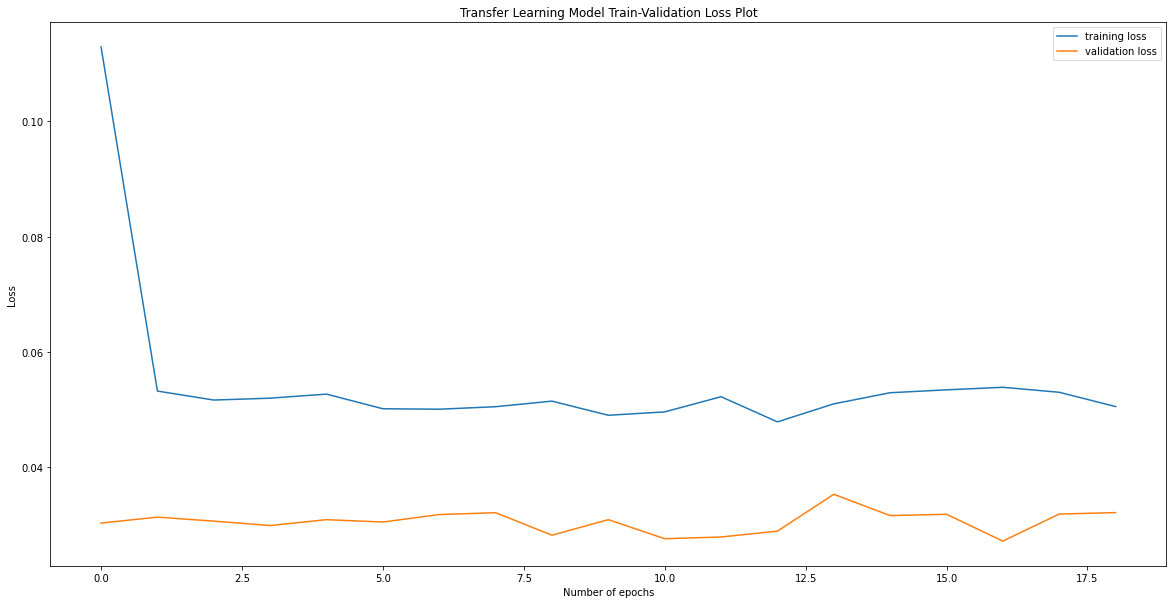

In [30]:
fig = plt.figure(figsize=(20,10))
plt.title("Transfer Learning Model Train-Validation Loss Plot")
plt.plot(trainingLossTransfer, label='training loss')
plt.plot(validationLossTransfer, label='validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend(loc='best')

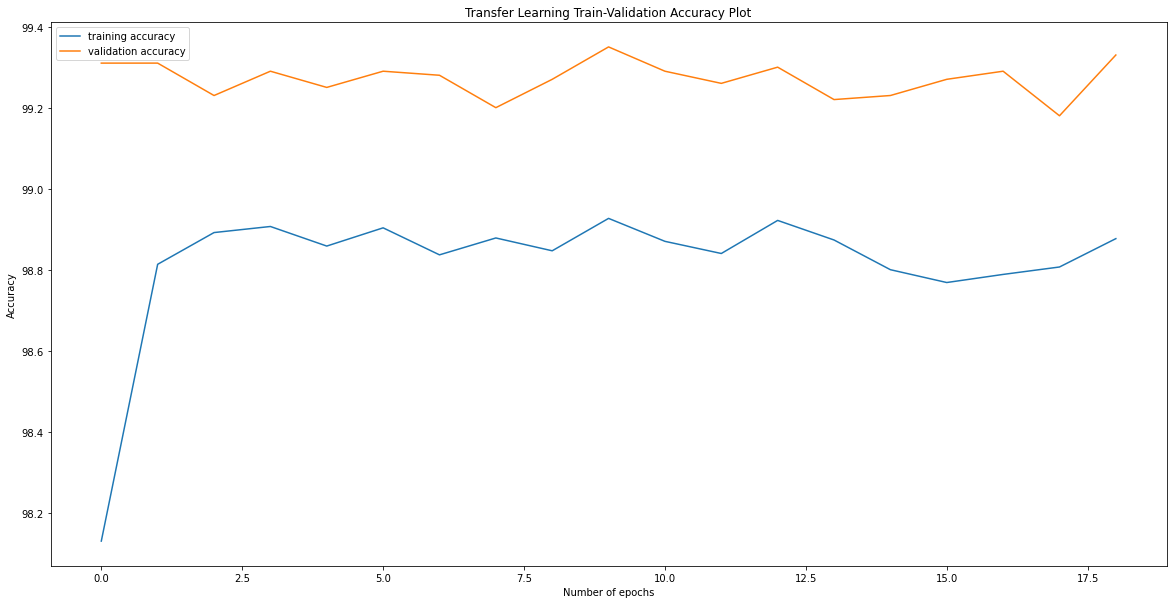

In [31]:
fig = plt.figure(figsize=(20,10))
plt.title("Transfer Learning Train-Validation Accuracy Plot")
plt.plot(trainingAccuracyTransfer, label='training accuracy')
plt.plot(validationAccuracyTransfer, label='validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')